In [1]:
import os
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.io import read_image

from my_utils import data, models
from my_utils.utils import check_accuracy
from my_utils.vis import grid_vis, Vis_cam

from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

In [2]:
print(f"torch version: {torch.__version__}")
use_cuda = torch.cuda.is_available()
if use_cuda:
    GPU_nums = torch.cuda.device_count()
    GPU = torch.cuda.get_device_properties(0)
    print(f"There are {GPU_nums} GPUs in total.\nThe first GPU is: {GPU}")
    if '3060' in GPU.name:
        print(f"CUDA version: {torch.cuda_version}")
    else:
        print(f"CUDA version: {torch.version.cuda}")
device = torch.device(f"cuda:{GPU_nums - 2}" if use_cuda else "cpu")
print(f"Using {device} now!")

torch version: 1.10.2
There are 8 GPUs in total.
The first GPU is: _CudaDeviceProperties(name='Tesla V100-SXM2-32GB', major=7, minor=0, total_memory=32510MB, multi_processor_count=80)
CUDA version: 11.3
Using cuda:6 now!


In [13]:
batch_size = 256
fig_resize = 64
# mean, std = torch.tensor(0.2036), torch.tensor(0.4027)  # polygons_unfilled_32_2
mean, std = torch.tensor(0.1094), torch.tensor(0.3660)  # polygons_unfilled_64_3
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize)),
    transforms.Normalize(mean, std)
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': True,         # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [14]:
# 制作二进制数据集
Dataset_DIR = '/home/wangyh/01-Projects/03-my/Datasets/polygons_unfilled_64_3'

test_data = data.MyDataset(os.path.join(Dataset_DIR, 'test'), transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

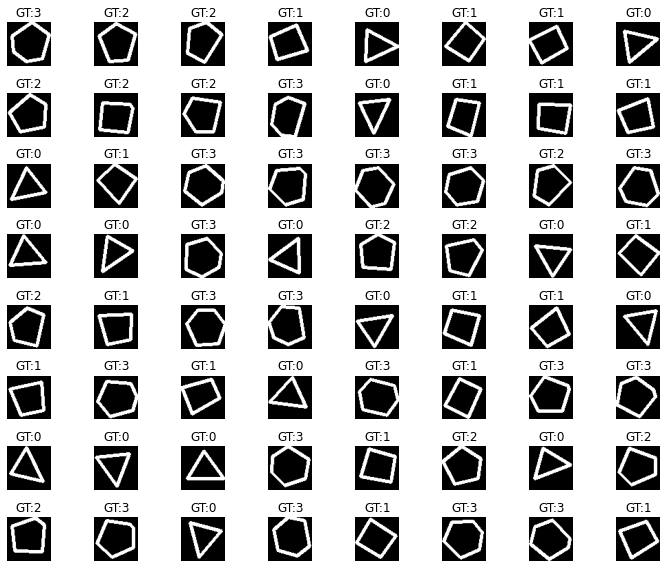

In [12]:
grid_vis(test_loader, 8)

In [64]:
# model = models.my_ConvNeXt(kernel_size=7, depths=(1, 2, 1), dims=(4, 8, 16))
model = models.simple_Conv(kernel_size=7, depths=(1, 2, 1), dims=(4, 8, 16))
if use_cuda:
    model.to(device)
print(model)

simple_Conv(
  (stages): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-4): ReLU()
    )
    (1): Sequential()
    (2): Sequential(
      (0): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-8): ReLU()
    )
    (3): Sequential(
      (0): Sequential(
        (0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): Sequential(
      (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu-16): ReLU()
    )
  )
  (head): Line

In [65]:
target_layers = [model.stages[-1]]
print(target_layers)

[Sequential(
  (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu-16): ReLU()
)]


In [66]:
# load modal weights
load_path = '/home/wangyh/01-Projects/03-my/newruns/simple_conv/KS_7_LR_1.5e-04_WD_0.005/2022_03_16_18_42_17/94_simple_conv_2022_03_16_19_04_07.pt'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [67]:
model = model.eval()
check_accuracy(model, test_loader)

Test accuracy is : 94.20%	Infer time: 1.237821102142334


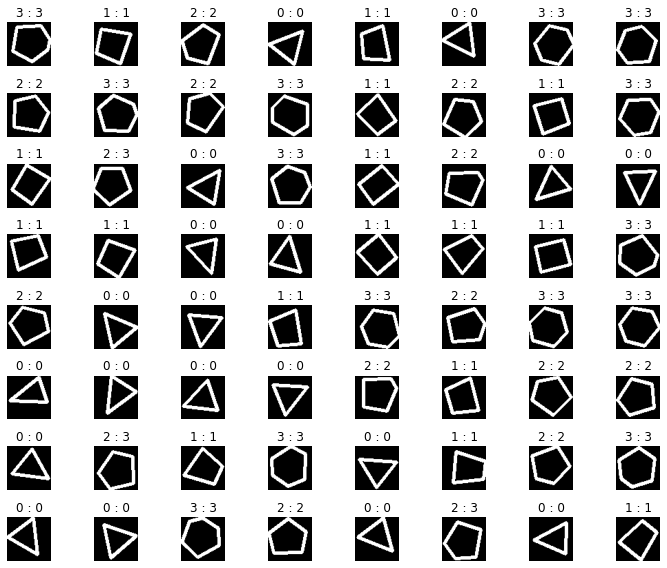

In [41]:
grid_vis(test_loader, 8, model)

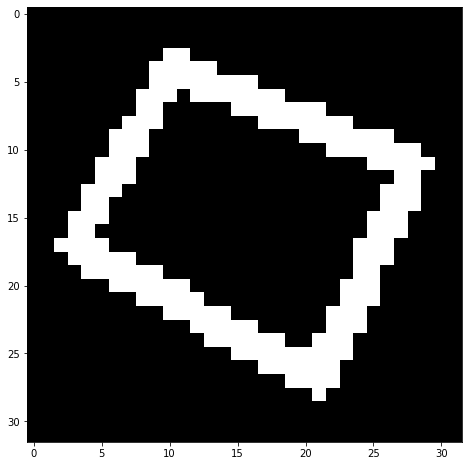

In [16]:
# Create an input tensor image for your model
img_path = "Datasets/polygons_unfilled_32_2/val/4/4_0.png"
# gray_img = read_image(img_path).numpy()
gray_img, label = test_data[2000]
# gray_img = gray_img / 255
plt.imshow(gray_img.squeeze(), 'gray')
input_tensor = gray_img[None, :, :, :].to(device, dtype=torch.float32)
# Note: input_tensor can be a batch tensor with several images!

In [17]:
with torch.no_grad():
    scores = model(input_tensor)
    print(scores, scores.argmax(axis=1))
    print(label)

tensor([[-0.1636,  0.1282,  0.0738,  0.0604]], device='cuda:7') tensor([1], device='cuda:7')
1


In [18]:
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.
# e.g. targets = [ClassifierOutputTarget(281)] # cat 281-287
# e.g. targets = [ClassifierOutputTarget(151)] # dog 151-268
targets = [ClassifierOutputTarget(1)]
# targets = None

In [19]:
# Construct the CAM object once, and then re-use it on many images:
with GradCAM(model=model, target_layers=target_layers, use_cuda=use_cuda) as cam:
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

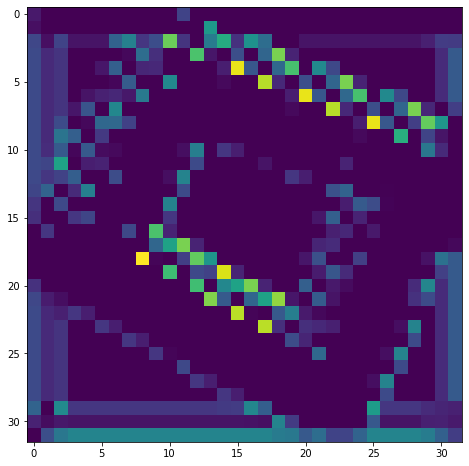

In [20]:
# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
plt.imshow(grayscale_cam)
plt.show()

(-0.5, 31.5, 31.5, -0.5)

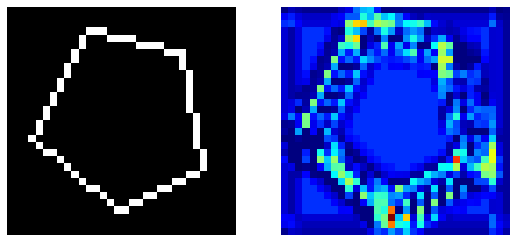

In [164]:
vis_cam = show_cam_on_image(gray_img.permute(1,2,0).numpy() / 255, grayscale_cam, use_rgb=True)

plt.figure(figsize=(9, 10))
plt.subplot(1, 2, 1)
plt.imshow(gray_img.permute(1,2,0), 'gray')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(vis_cam)
plt.axis("off")

In [188]:
target_layers = [model.stages[0][0], model.norm_layers[0]]
print(target_layers)

[Block(
  (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
  (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
  (pwconv1): Linear(in_features=8, out_features=16, bias=True)
  (act): ReLU()
  (pwconv2): Linear(in_features=16, out_features=8, bias=True)
), BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)]


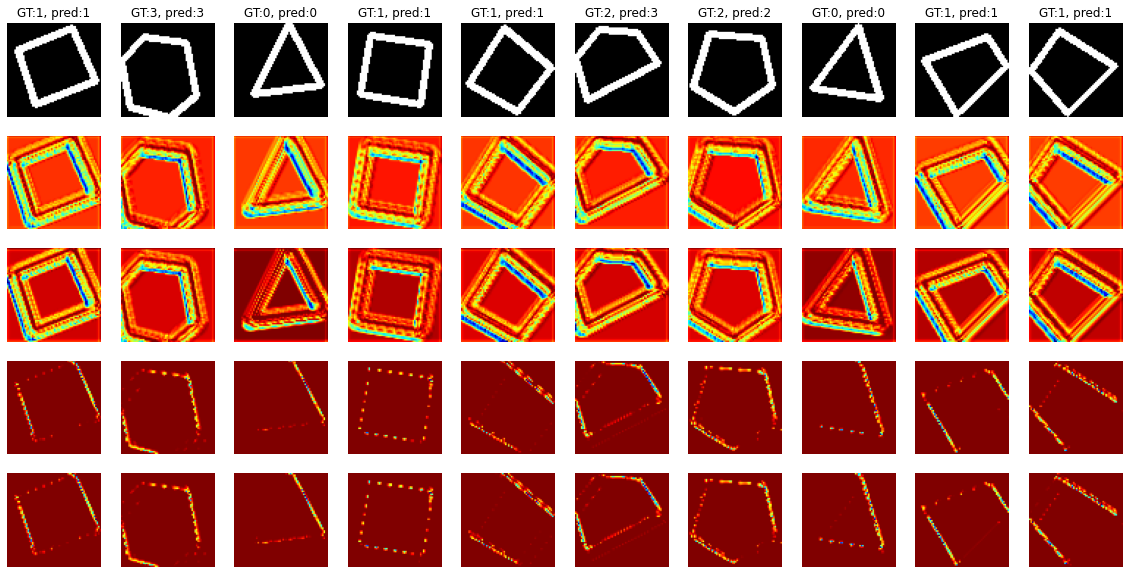

In [49]:
Vis_cam(test_loader, model, target_layers=[model.stages[0][0]], img_num=10)

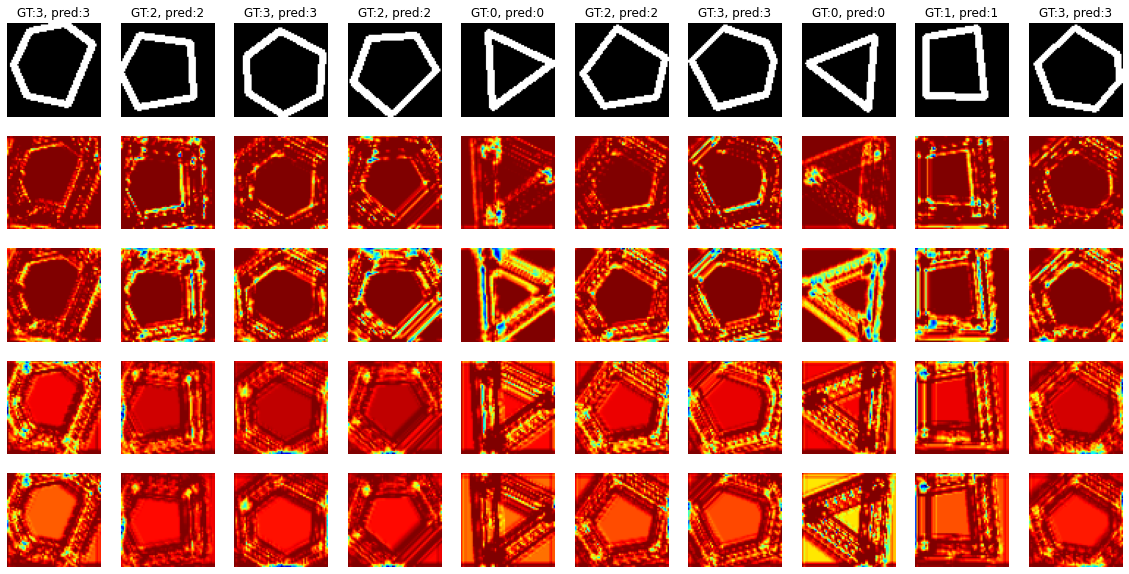

In [48]:
Vis_cam(test_loader, model, target_layers=[model.stages[1][1]], img_num=10)

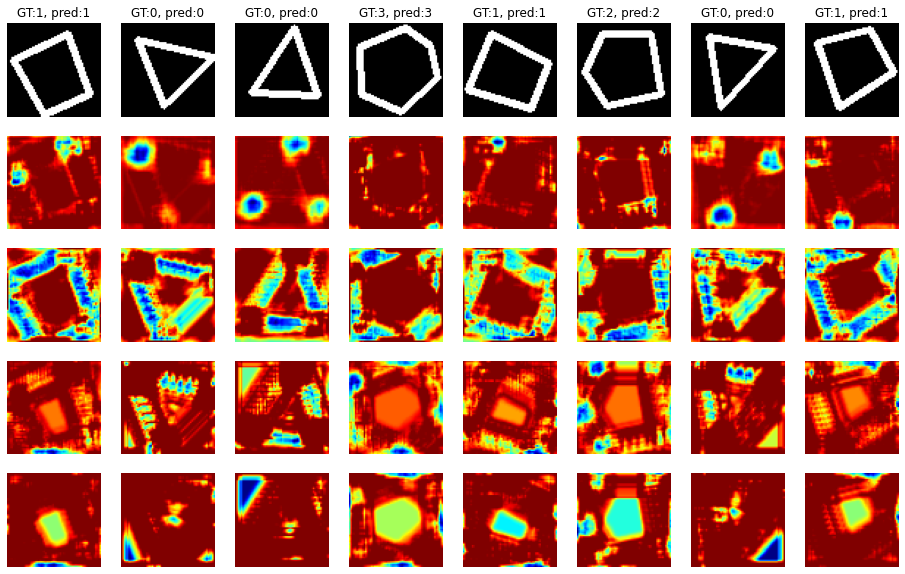

In [70]:
Vis_cam(test_loader, model, target_layers=[model.stages[-1][2]], img_num=8, mode="heatmap_only")

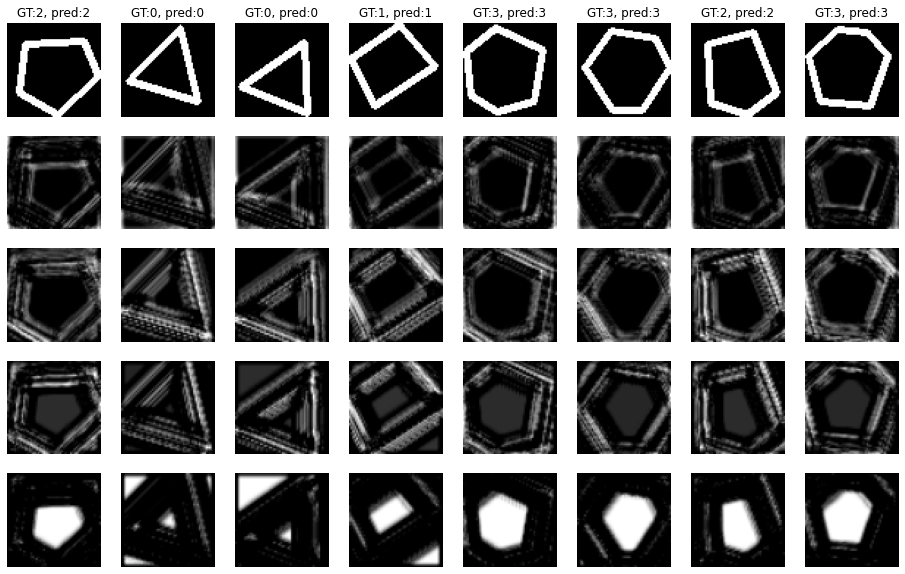

In [20]:
Vis_cam(test_loader, model, target_layers=[model.stages[2][0]], img_num=8, mode="cam_on_img")

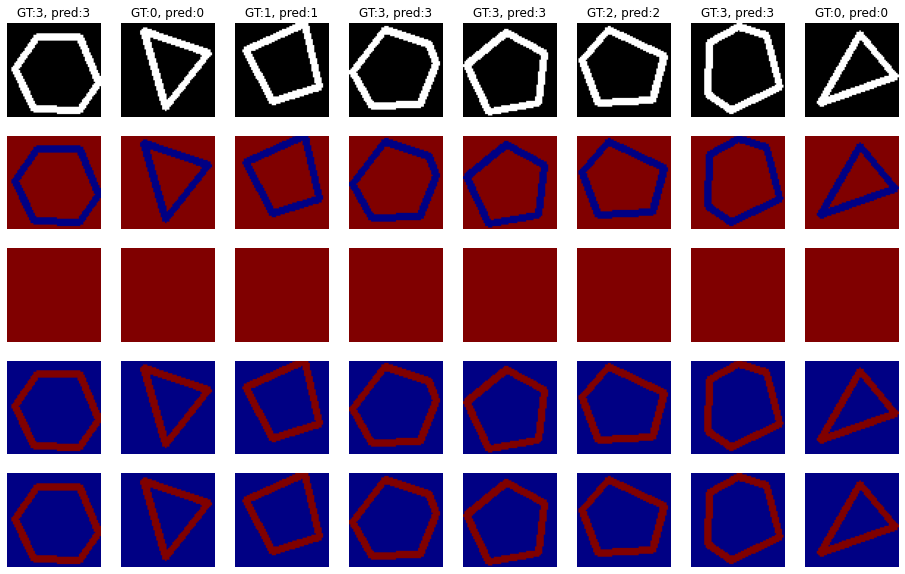

In [25]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[0]])

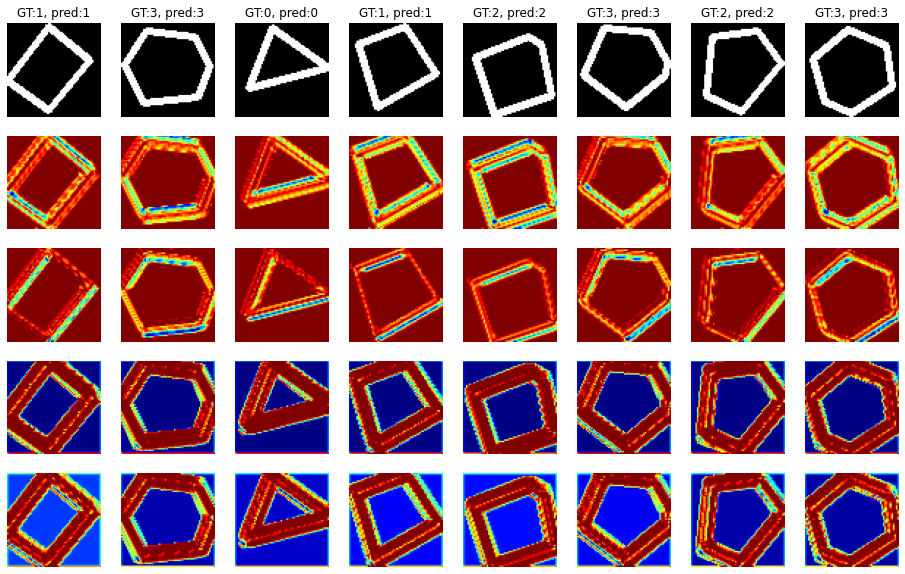

In [23]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[1]])

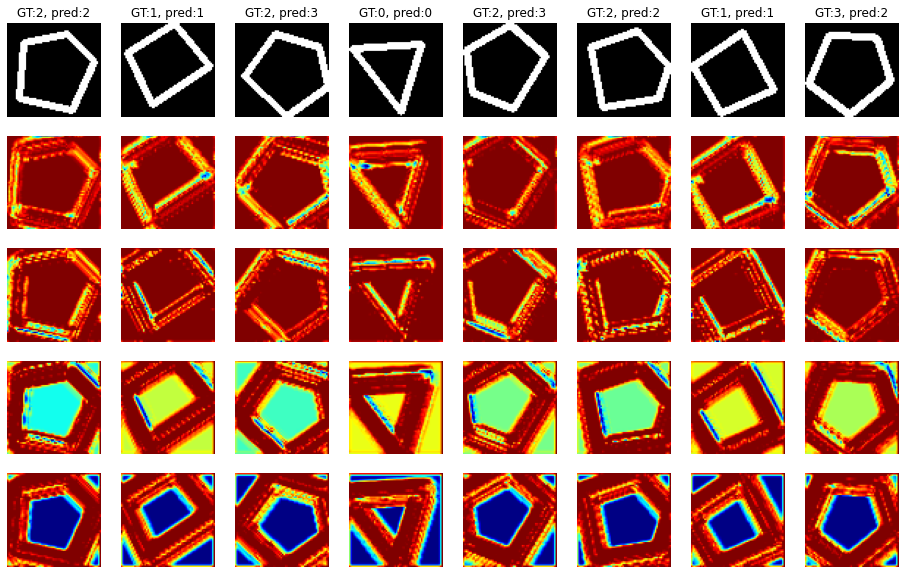

In [24]:
Vis_cam(test_loader, model, target_layers=[model.norm_layers[2]])